# Mount drive and append path to PYTONPATH


In [1]:
import os
import sys

from google.colab import drive

drive.mount("/content/drive")
sys.path.append("/content/drive/MyDrive/DeepLCMS/train_google_colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import and install libraries

In [10]:
%%capture
!pip install lightning
!pip install timm
!pip install torchinfo
!pip install torchmetrics

In [11]:
from pathlib import Path

import colab_functions
import colab_utils
import pandas as pd
import prepare_data

import timm
import torch
import torchinfo
import train_NN
from google.colab import drive
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning import LightningModule
from pytorch_lightning.trainer.trainer import Trainer
from timm import create_model
import torchmetrics

In [4]:
# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Unzip data

In [9]:
!unzip -q "*.zip"

[ST001618_Opium_study_LC_MS_500_augmented.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.

1 archive was successfully processed.
1 file had no zipfile directory.


# Check if GPU is used

In [3]:
device = colab_functions.get_device()

Using CPU


# Final training with optimized settings

In [3]:
model = train_NN.Resnet_model()

In [8]:
train_NN.show_architecture(model)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Resnet_model (Resnet_model)                   [32, 3, 384, 384]    [32, 1]              --                   Partial
├─ResNet (model)                              [32, 3, 384, 384]    [32, 1]              --                   Partial
│    └─Sequential (conv1)                     [32, 3, 384, 384]    [32, 64, 192, 192]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 384, 384]    [32, 32, 192, 192]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 192, 192]   [32, 32, 192, 192]   (64)                 False
│    │    └─ReLU (2)                          [32, 32, 192, 192]   [32, 32, 192, 192]   --                   --
│    │    └─Conv2d (3)                        [32, 32, 192, 192]   [32, 32, 192, 192]   (9,216)              False
│    │    └─BatchNorm2d (4)                   [32, 32, 192, 192]   [32, 32,

In [4]:
(
    preprocess_train,
    preprocess_val,
    preprocess_test,
) = prepare_data.get_timm_transforms(model)

(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = prepare_data.get_dataloaders(
    preprocess_train=preprocess_train,
    preprocess_val=preprocess_val,
    preprocess_test=preprocess_test,
)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/content/lightning_logs'

In [5]:
logger = TensorBoardLogger("lightning_logs", name="final_training")

trainer = Trainer(
    max_epochs=3,
    log_every_n_steps=1,
    logger=logger,
)

trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 24.7 M
---------------------------------
1.2 M     Trainable params
23.5 M    Non-trainable params
24.7 M    Total params
98.832    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


# Evaluate the test set


In [6]:
predictions = trainer.predict(model, test_dataloader)

Predicting: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.73 | F1: 0.85 | Precision: 0.85 | Recall : 0.85


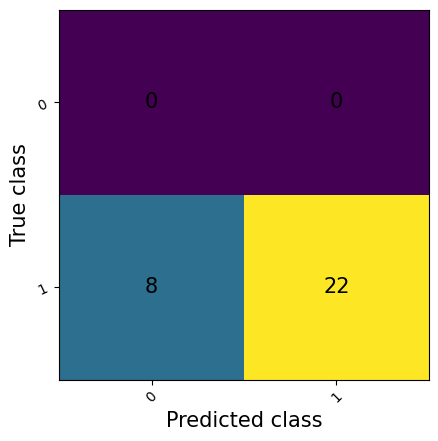

In [111]:
def evaluate_predictions(logits, test_dataloader=test_dataloader):
    true_labels = torch.tensor(test_dataloader.dataset.targets)

    probabilities = torch.sigmoid((torch.cat(logits, dim=0)))

    # Threshold probabilities to get binary predictions (0 or 1)
    threshold = 0.5
    binary_predictions = (probabilities > threshold).float().view(-1)

    acc = (all_labels == binary_predictions).sum().item() / len(all_labels)

    metric_f1 = torchmetrics.classification.BinaryF1Score()
    f1 = metric_f1(true_labels, binary_predictions)

    metric_precision = torchmetrics.classification.BinaryPrecision()
    precision = metric_f1(true_labels, binary_predictions)

    metric_recall = torchmetrics.classification.BinaryRecall()
    recall = metric_f1(true_labels, binary_predictions)

    bcm = torchmetrics.classification.BinaryConfusionMatrix()
    bcm(true_labels, binary_predictions)

    print(
        f"Accuracy: {acc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall : {recall:.2f}"
    )
    fig_, ax_ = bcm.plot(add_text=True)


evaluate_predictions(logits=predictions)

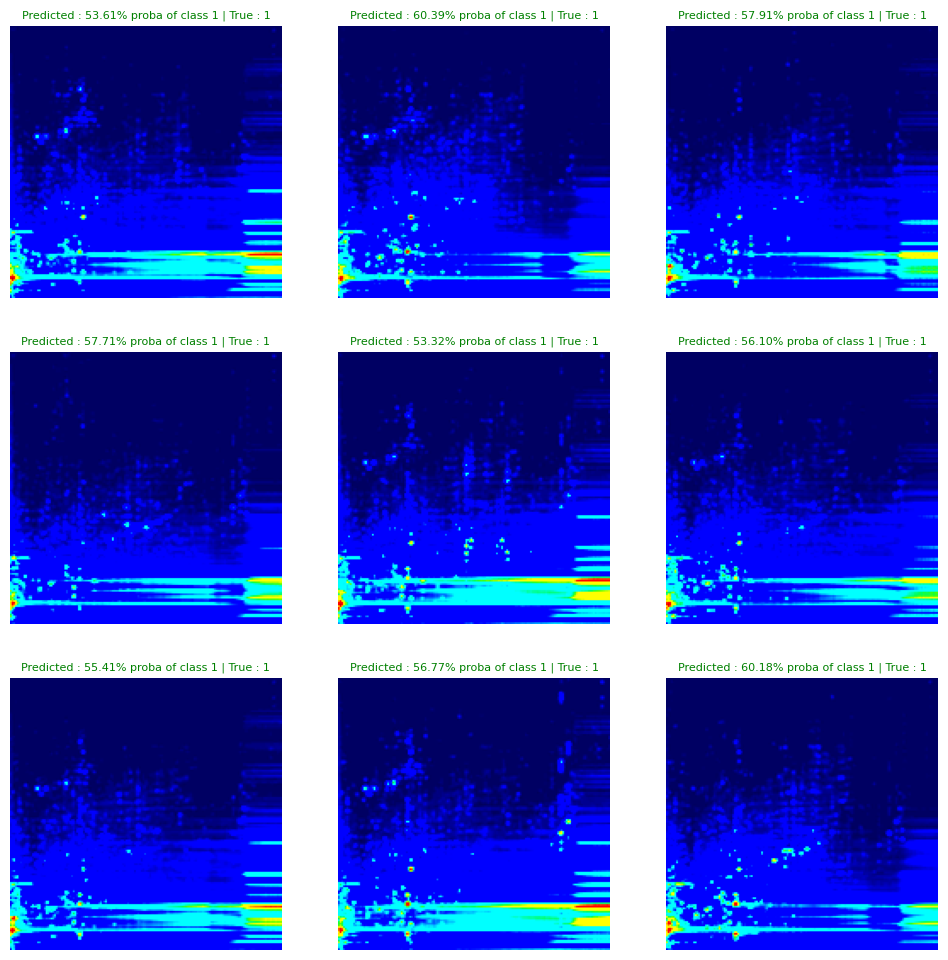

In [96]:
def inspect_predictions(logits, test_dataloader=test_dataloader):
    images, labels = next(iter(test_dataloader))

    first_batch_of_logits = logits[: test_dataloader.batch_size]
    probabilities = torch.sigmoid((torch.cat(first_batch_of_logits, dim=0))).squeeze()

    threshold = 0.5
    predicted_labels = (probabilities > threshold).float().view(-1)

    # Create a 3x3 grid for displaying images
    fig = plt.figure(figsize=(12, 12))
    rows, cols = 3, 3

    for i in range(1, rows * cols + 1):
        fig.add_subplot(rows, cols, i)

        # Choose a random index
        random_index = np.random.randint(0, (probabilities.shape[0]) - 1)
        title = f"Predicted : {probabilities[random_index].item():.2%} proba of class 1 | True : {int(predicted_labels[random_index])}"
        color = (
            "g"
            if probabilities[random_index].item() > 0.5
            and int(predicted_labels[random_index]) == 1
            else "r"
        )
        plt.title(title, fontsize=8, color=color)
        plt.imshow(images[random_index].permute(1, 2, 0))

        plt.axis(False)


inspect_predictions(logits=predictions)